# Autoregressive Flow - 2D

In [1]:
import os
import pickle

import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as D



In [2]:
def sample_data():
    count = 100000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(100000 - 2 * count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
    -np.sin(np.linspace(0, np.pi, count // 3))]
    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm], data_y[perm]

### Sample data

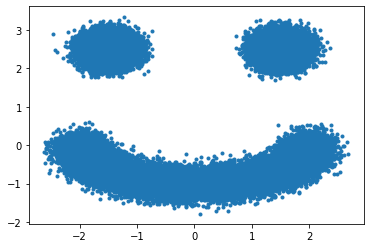

In [3]:
x, y = sample_data()
plt.scatter(x[:, 0], x[:, 1], marker='.')

x_train = x[:int(len(x) * 0.8)]
x_test = x[int(len(x) * 0.8):]

## Part (a) Autoregressive Flow

In [4]:
class MaskedLinear(nn.Linear):
    
    def __init__(self, in_features, out_features, bias=True):
        super(MaskedLinear, self).__init__(in_features, out_features, bias=bias)
        self.register_buffer("mask", torch.ones([out_features, in_features]).float())
        
    def set_mask(self, mask):
        self.mask = mask.data
        
    def forward(self, x):
        return F.linear(x, self.mask * self.weight, self.bias)
    
    
class PiNet(nn.Module):

    def __init__(self, k, hidden_size):
        super(PiNet, self).__init__()
        self.k = k
        self.h = hidden_size
        
        self.linear1 = MaskedLinear(2, self.h)
        mask1 = np.ones([self.h, 2], dtype=np.float32)
        mask1[:, 1] = 0.0
        self.linear1.set_mask(torch.from_numpy(mask1))
        
        self.linear2 = MaskedLinear(self.h, 2 * k)
        mask2 = np.ones([2 * k, self.h], dtype=np.float32)
        mask2[:k, :] = 0.0
        self.linear2.set_mask(torch.from_numpy(mask2))
        
    def forward(self, x):

        h = F.relu(self.linear1(x))
        out = self.linear2(h)
        out = out.reshape([-1, 2, self.k])
        out = F.softmax(out, dim=2)
        return out
    
    
class MuNet(nn.Module):
    
    def __init__(self, k, hidden_size):

        super(MuNet, self).__init__()
        self.k = k
        self.h = hidden_size
        
        self.linear1 = MaskedLinear(2, self.h)
        mask1 = np.ones([self.h, 2], dtype=np.float32)
        mask1[:, 1] = 0.0
        self.linear1.set_mask(torch.from_numpy(mask1))
        
        self.linear2 = MaskedLinear(self.h, 2 * k)
        mask2 = np.ones([2 * k, self.h], dtype=np.float32)
        mask2[:k, :] = 0.0
        self.linear2.set_mask(torch.from_numpy(mask2))
        
    def forward(self, x):

        out = self.linear2(F.relu(self.linear1(x)))
        return out.view([-1, 2, self.k])
    
class VarNet(nn.Module):

    def __init__(self, k, hidden_size):

        super(VarNet, self).__init__()
        self.k = k
        self.h = hidden_size
        
        self.linear1 = MaskedLinear(2, self.h)
        mask1 = np.ones([self.h, 2], dtype=np.float32)
        mask1[:, 1] = 0.0
        self.linear1.set_mask(torch.from_numpy(mask1))
        
        self.linear2 = MaskedLinear(self.h, 2 * k)
        mask2 = np.ones([2 * k, self.h], dtype=np.float32)
        mask2[:k, :] = 0.0
        self.linear2.set_mask(torch.from_numpy(mask2))
        
    def forward(self, x):

        out =  torch.exp(self.linear2(F.relu(self.linear1(x))))
        return out.view([-1, 2, self.k])


In [5]:
def getNLL(x, piNetNet, muNet, varNet):
    pi = piNetNet(x)
    mu = muNet(x)
    var = varNet(x)

    weighted_density = pi * (torch.exp(- torch.pow(x.unsqueeze(2) - mu, 2) / (2 * var)) / torch.sqrt(2 * np.pi * var))
    density = torch.sum(weighted_density, dim=2)
    abs_det = torch.log(torch.abs(density[:, 0] * density[:, 1]))
    return -abs_det

def getDensity(x, piNet, muNet, varNet):
    nll = getNLL(x, piNet, muNet, varNet).detach()
    return torch.exp(-nll)

def getLatent(x, piNet, muNet, varNet):
    pi = piNet(x)
    mu = muNet(x)
    var = varNet(x)

    z = torch.sum(pi * (torch.erf((x.unsqueeze(2) - mu) / torch.sqrt(2 * var)) + 1) * 0.5, dim=2)
    return z

In [6]:
k = 10
piNet = PiNet(k, 100).cuda()
muNet = MuNet(k, 100).cuda()
varNet = VarNet(k, 100).cuda()
lr = 1e-3

pi_optim = optim.Adam(piNet.parameters(), lr=lr)
mu_optim = optim.Adam(muNet.parameters(), lr=lr)
var_optim = optim.Adam(varNet.parameters(), lr=lr)

n_epochs = 10
batch_size = 125
n_iter_per_epoch = x_train.shape[0] // batch_size
val_steps = n_iter_per_epoch // 8

train_log = []
val_log = []
global_step = 0

for epoch in range(n_epochs):
    idx = np.random.permutation(x_train.shape[0])
    for i in range(n_iter_per_epoch):
        batch = torch.from_numpy(x_train[idx[i * batch_size: (i + 1) * batch_size], :]).float().cuda()
        
        nll = getNLL(batch, piNet, muNet, varNet)
        loss = torch.sum(nll)
        
#         print("Epoch-{:d}/{:d} Iter-{:d}/{:d}: Loss-{:.5f}".format(epoch + 1, n_epochs, i + 1, n_iter_per_epoch, loss.item()))
        
        pi_optim.zero_grad()
        mu_optim.zero_grad()
        var_optim.zero_grad()
        
        loss.backward()
        
        pi_optim.step()
        mu_optim.step()
        var_optim.step()
        
        train_nll = loss.detach() / (batch_size * 2 * np.log(2))
        train_log.append(train_nll.item())
        
        global_step += 1
        

        if (global_step % val_steps == 0):
            val_nll = torch.mean(getNLL(torch.from_numpy(x_test).float().cuda(), piNet, muNet, varNet).detach())
            val_nll = val_nll / (2 * np.log(2))
            val_log.append(val_nll.item())


# results

In [8]:
nll = getNLL(torch.from_numpy(x_test).float().cuda(), piNet, muNet, varNet).detach()
nll = torch.sum(nll)
bits_per_dim = nll / x_test.shape[0] / 2 / np.log(2)
print("Test set performance: {:.5f} bits/dim".format(bits_per_dim.item()))

Test set performance: 0.97021 bits/dim


In [10]:
d = np.linspace(-4, 4, 100)
samples = np.array(np.meshgrid(d, d)).T.reshape([-1, 2])
samples = torch.from_numpy(samples).float().cuda()
pdf = getDensity(samples, piNet, muNet, varNet).cpu().data.numpy().reshape(100, 100)

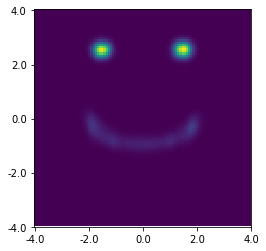

In [11]:
plt.imshow(np.rot90(pdf, 1))
_ = plt.xticks(np.linspace(0, 100, 5), np.linspace(-4, 4, 5))
_ = plt.yticks(np.linspace(0, 100, 5), np.linspace(4, -4, 5))

# Part (b) RealNVP

In [ ]:
with open('./hw2_q2.pkl', 'rb') as f:
    dataset = pickle.load(f)

dataset['train'] = dataset['train']  + np.random.uniform(size=dataset['train'].shape)
dataset['test'] = dataset['test']  + np.random.uniform(size=dataset['test'].shape)
x_train = np.transpose(dataset['train'], [0, 3, 1, 2])
x_test = np.transpose(dataset['test'], [0, 3, 1, 2])

## preprocessing

In [ ]:
def logit(x, reverse=False):
    if not reverse:
        z = torch.log(x) - torch.log(1.0 - x)
        diag = torch.flatten(torch.abs(1.0 / x + 1.0 / (1.0 - x)), start_dim=1)
        logdet = torch.sum(torch.log(diag + 1e-6), dim=1, keepdim=True)
        return z, logdet
    else:
        z = torch.exp(x)
        return z / (z + 1.0)

    
def dequantize(x, alpha=0.05, reverse=False):
    if not reverse:
        z = alpha + (1.0 - alpha) * x / 4.0
        diag = torch.flatten(torch.ones_like(x) * (1.0 - alpha) / 4.0, start_dim=1)
        logdet = torch.sum(torch.log(torch.abs(diag)), dim=1, keepdim=True)
        return z, logdet
    else:
        z = 4.0 * (x - alpha) / (1.0 - alpha)
        return z
    
    
def preprocess(x, alpha=0.05, reverse=False):
    if not reverse:
        deq, logdet1 = dequantize(x, alpha, reverse)
        z, logdet2 = logit(deq, reverse)
        logdet = logdet1 + logdet2
        return z, logdet
    else:
        z = logit(x, reverse)
        z = dequantize(z, alpha, reverse)
        return z

In [ ]:
class ResidualBlock(nn.Module):
    
    def __init__(self, n_in, n_filters=32):
        super(ResidualBlock, self).__init__()
        self.n_in = n_in
        self.n_filters = n_filters
        self.conv1 = nn.Conv2d(self.n_in, self.n_filters, (1, 1))
        self.conv2 = nn.Conv2d(self.n_filters, self.n_filters, (3, 3), padding=1)
        self.conv3 = nn.Conv2d(self.n_filters, self.n_in, (1, 1))
        
    def forward(self, x):
        x_ = torch.relu(self.conv1(x))
        x_ = torch.relu(self.conv2(x_))
        x_ = self.conv3(x_)
        return x + x_


class SimpleResNet(nn.Module):
    
    def __init__(self, n_in=3, n_filters=32, n_blocks=4):
        super(SimpleResNet, self).__init__()
        self.n_in = n_in
        self.n_out = n_in * 2
        self.n_filters = n_filters
        self.n_blocks = n_blocks
        
        self.conv1 = nn.Conv2d(self.n_in, self.n_filters, (3, 3), padding=1)
        self.blocks = nn.ModuleList()
        
        for _ in range(self.n_blocks):
            self.blocks.append(ResidualBlock(self.n_filters, self.n_filters))
            
        self.conv2 = nn.Conv2d(self.n_filters, self.n_out, (3, 3), padding=1)
        
        
    def forward(self, x):
        h = self.conv1(x)
        for block in self.blocks:
            h = block(h)
        h = torch.relu(h)
        x = self.conv2(h)
        return x

In [ ]:
class AffineCouplingLayer(nn.Module):
    
    def __init__(self, c=3, h=32, w=32, n_filters=32, n_blocks=4, mask=None):
        super(AffineCouplingLayer, self).__init__()
        self.register_buffer("mask", torch.ones([1, c, h, w], dtype=torch.float32))
        
        if mask is not None:
            self.mask.data.copy_(mask)
            
        self.c = c
        self.n_filters = n_filters
        self.n_blocks = n_blocks
        self.resNet = SimpleResNet(self.c, self.n_filters, self.n_blocks)
    
    def forward(self, x, reverse=False):
        if not reverse:
            z = self.mask * x
            log_s, t = torch.split(self.resNet(z), z.shape[1], dim=1)
            log_s = torch.tanh(log_s)
            z = z + (1.0 - self.mask) * (torch.exp(log_s) * x + t)
            logdet = torch.sum(torch.flatten(log_s * (1.0 - self.mask), start_dim=1), dim=1, keepdim=True)
            return z, logdet
        else:
            z = self.mask * x
            log_s, t = torch.split(self.resNet(z), z.shape[1], dim=1)
            log_s = torch.tanh(log_s)
            z = z + (1.0 - self.mask) * (x - t) / torch.exp(log_s)
            return z

In [ ]:
def buildCheckerboardMask(c, h, w):
    maskA = np.ones([1, c, h, w], dtype=np.bool)
    maskB = np.ones([1, c, h, w], dtype=np.bool)
    even_idx = [i for i in range(w) if not i & 1]
    odd_idx = [i for i in range(h) if i & 1]
    maskA[:, :, odd_idx,:] = False 
    maskB[:, :, :, even_idx] = False
    mask = maskA ^ maskB
    return torch.from_numpy(mask).float()


def squeeze(x):
    n, c, h, w = x.shape
    return F.unfold(x, (2, 2), stride=2).reshape([n, 4 * c, h // 2, w // 2])


def unsqueeze(x):
    n, c, h, w = x.shape
    return F.fold(x.reshape([n, c, -1]), (h * 2, w * 2), (2, 2), stride=2)


def buildChannelSplitMask(c, h, w):
    mask = torch.zeros([1, c, h, w], dtype=torch.float32)
    idx = np.array([[4 * i, 4 * i + 1] for i in range(c // 4)]).reshape(-1)

    mask[:, idx, :, :] = 1.0
    return mask

In [ ]:
class ActNorm(nn.Module):
    
    def __init__(self, c, h, w):
        super(ActNorm, self).__init__()
        self.register_parameter("s", nn.Parameter(torch.ones([1, c, h, w])))
        self.register_parameter("b", nn.Parameter(torch.zeros([1, c, h, w])))
        
    def initialize(self, x):
        std = torch.std(x, dim=0, keepdim=True)
        self.s.data.copy_(1.0 / std)
        self.b.data.copy_(-torch.mean(x * self.s, dim=0, keepdim=True))
        
    def forward(self, x, reverse=False):
        if not reverse:
            logdet = torch.sum(torch.flatten(torch.log(torch.abs(self.s) + 1e-6), start_dim=1), dim=1, keepdim=True)
            out = x * self.s + self.b
            return out, logdet
        else:
            out = (x - self.b) / self.s
            return out

In [ ]:
class RealNVP(nn.Module):
    
    def __init__(self):
        super(RealNVP, self).__init__()
        self.affLayers1 = nn.ModuleList()
        mask = buildCheckerboardMask(3, 32, 32)
        for _ in range(4):
            self.affLayers1.append(AffineCouplingLayer(3, 32, 32, mask=mask))
            self.affLayers1.append(ActNorm(3, 32, 32))
            mask = 1.0 - mask 
        
        self.affLayers2 = nn.ModuleList()
        mask = buildChannelSplitMask(12, 16, 16)
        for _ in range(3):
            self.affLayers2.append(AffineCouplingLayer(12, 16, 16, mask=mask))
            self.affLayers2.append(ActNorm(12, 16, 16))
            mask = 1.0 - mask
        
        self.affLayers3 = nn.ModuleList()
        mask = buildCheckerboardMask(12, 16, 16)
        for _ in range(3):
            self.affLayers3.append(AffineCouplingLayer(12, 16, 16, mask=mask))
            self.affLayers3.append(ActNorm(12, 16, 16))
            mask = 1.0 - mask # Flip mask
            
        self.affLayers4 = nn.ModuleList()
        mask = buildChannelSplitMask(48, 8, 8)
        for _ in range(3):
            self.affLayers4.append(AffineCouplingLayer(48, 8, 8, mask=mask))
            self.affLayers4.append(ActNorm(48, 8, 8))
            mask = 1.0 - mask
            
        self.affLayers5 = nn.ModuleList()
        mask = buildCheckerboardMask(48, 8, 8)
        for i in range(3):
            self.affLayers5.append(AffineCouplingLayer(48, 8, 8, mask=mask))
            self.affLayers5.append(ActNorm(48, 8, 8))
            mask = 1.0 - mask # Flip mask
    
    def forward(self, x, reverse=False):
        if not reverse:
            x, logdet = preprocess(x)
            for layer in self.affLayers1:
                x, cur_logdet = layer(x)
                logdet = logdet + cur_logdet
                
            x = squeeze(x)
            for layer in self.affLayers2:
                x, cur_logdet = layer(x)
                logdet = logdet + cur_logdet
            for layer in self.affLayers3:
                x, cur_logdet = layer(x)
                logdet = logdet + cur_logdet

            x = squeeze(x)
            for layer in self.affLayers4:
                x, cur_logdet = layer(x)
                logdet = logdet + cur_logdet
            for layer in self.affLayers5:
                x, cur_logdet = layer(x)
                logdet = logdet + cur_logdet

            x = unsqueeze(x)
            x = unsqueeze(x)
            return x, logdet
        else:
            x = squeeze(x)
            x = squeeze(x)
            for layer in reversed(self.affLayers5):
                x = layer(x, reverse=reverse)
            for layer in reversed(self.affLayers4):
                x = layer(x, reverse=reverse)
            x = unsqueeze(x)
            for layer in reversed(self.affLayers3):
                x = layer(x, reverse=reverse)
            for layer in reversed(self.affLayers2):
                x = layer(x, reverse=reverse)
            x = unsqueeze(x)
            for layer in reversed(self.affLayers1):
                x = layer(x, reverse=reverse)
            x = preprocess(x, reverse=reverse)
            return x

    def initialize(self, x):
        with torch.no_grad():
            x, _ = preprocess(x)
            for layer in self.affLayers1:
                if isinstance(layer, ActNorm):
                    layer.initialize(x)
                x, _ = layer(x)    
                
            x = squeeze(x)
            for layer in self.affLayers2:
                if isinstance(layer, ActNorm):
                    layer.initialize(x)
                x,  _ = layer(x)
            for layer in self.affLayers3:
                if isinstance(layer, ActNorm):
                    layer.initialize(x)
                x, _ = layer(x)
                
            x = squeeze(x)
            for layer in self.affLayers4:
                if isinstance(layer, ActNorm):
                    layer.initialize(x)
                x, _ = layer(x)
            for layer in self.affLayers5:
                if isinstance(layer, ActNorm):
                    layer.initialize(x)
                x, _ = layer(x)
                
                
def getNLL(z, logdet):
#     pz = torch.exp(-torch.pow(z, 2) / 2) / np.sqrt(2 * np.pi)
    m = D.normal.Normal(0, 1)
    log_pz = m.log_prob(z) 
    log_pz = torch.sum(torch.flatten(log_pz, start_dim=1), dim=1, keepdim=True)
    nll = -(log_pz + logdet)
    return nll

## training

In [ ]:


batch_size = 64
n_epochs = 100
train_size = x_train.shape[0]
n_iter_per_epoch = train_size // batch_size
val_steps = n_iter_per_epoch // 8
lr = 1e-3
logs = {}

net = RealNVP().cuda()
opt = optim.Adam(net.parameters(), lr=lr)

train_log = []
val_log = []
global_step = 0

sample_idx = np.random.choice(np.arange(0, train_size), 128)
init_batch = torch.from_numpy(x_train[sample_idx]).float().cuda()
net.initialize(init_batch)

for epoch in range(n_epochs):
    idx = np.random.permutation(train_size)
    for i in range(n_iter_per_epoch):
        global_step += 1

        batch = torch.from_numpy(x_train[idx[i * batch_size: (i + 1) * batch_size], :]).float().cuda()
        z, logdet = net(batch)
        nll = getNLL(z, logdet)
        loss = torch.sum(nll, dim=0)
        
        opt.zero_grad()
        loss.backward()
        opt.step()

#         print("Epoch-{:d}/{:d} Iter-{:d}/{:d}: Loss-{:.5f}".format(epoch + 1, n_epochs, i + 1, n_iter_per_epoch, loss.item()))
        train_nll = loss.detach() / (batch_size * 32 * 32 * 3 * np.log(2))
        train_log.append(train_nll.item())

        if (global_step % val_steps == 0):
            with torch.no_grad():
                start_idx = 0
                val_size = x_test.shape[0]
                val_nll = torch.zeros([1]).float().cuda()
                while start_idx < val_size:
                    end_idx = min(val_size, start_idx + batch_size)
                    val_z, val_logdet = net(torch.from_numpy(x_test[start_idx:end_idx]).float().cuda())
                    val_nll = val_nll + torch.sum(getNLL(val_z, val_logdet))
                    start_idx += batch_size
                val_log.append(val_nll.item() / (val_size * 32 * 32 * 3 * np.log(2)))

# bad masking schemes